In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

batch_size = 128

train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

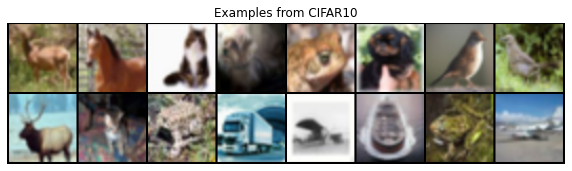

In [4]:
real_batch = next(iter(train_loader))
plt.figure(figsize=(10,10))
plt.axis("off")
plt.title("Examples from CIFAR10")
plt.imshow(np.transpose(torchvision.utils.make_grid(real_batch[0].to(device)[:16], normalize=True).cpu(),(1,2,0)))

In [5]:
momentum = 0.5

class Generator(nn.Module):
    def __init__(self, noise_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(noise_dim, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512, momentum=momentum),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256, momentum=momentum),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128, momentum=momentum),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64, momentum=momentum),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, noise):
        return self.model(noise)

#discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128, momentum=momentum),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256, momentum=momentum),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512, momentum=momentum),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.model(input).view(-1, 1).squeeze(1)

In [6]:
# define the generator and discriminator and noise dimention
noise_dim = 100
generator = Generator(noise_dim).to(device)
discriminator = Discriminator().to(device)


# Using the papers recommendations for lr, beta and optimizer
criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [7]:
# setup arrays for capturing loss for plotting
num_epochs = 50
g_losses = []
d_losses = []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(train_loader):
        real_images = images.to(device)
        batch_size = real_images.size(0)
        noise = torch.randn(batch_size, 100, 1, 1, device=device)

        optimizer_D.zero_grad()

        # Training discriminator
        real_output = discriminator(real_images)
        real_loss = criterion(real_output, torch.ones(batch_size, device=device))
        fake_images = generator(noise)
        fake_output = discriminator(fake_images.detach())
        fake_loss = criterion(fake_output, torch.zeros(batch_size, device=device))
        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_D.step()
        d_losses.append(d_loss.item())

        # training generator
        optimizer_G.zero_grad()
        fake_output = discriminator(fake_images)
        g_loss = criterion(fake_output, torch.ones(batch_size, device=device))
        g_loss.backward()
        optimizer_G.step()
        g_losses.append(g_loss.item())

    # have a folder for generated images each epoch, so I can see progress
    with torch.no_grad():
        test_noise = torch.randn(batch_size, noise_dim, 1, 1, device=device)
        generated_images = generator(test_noise)
        save_image(generated_images.data[:64], f'generated_images/epoch_{epoch+1}.png', nrow=8, normalize=True)
        
    print(f"Epoch [{epoch+1}/{num_epochs}], Last batch: D_loss: {d_loss.item():.4f}, G_loss: {g_loss.item():.4f}")
            
# Save the generator & discriminator
torch.save(generator.state_dict(), 'generator_state_dict.pth')
torch.save(discriminator.state_dict(), 'discriminator_state_dict.pth')

Epoch [1/50], Last batch: D_loss: 0.3886, G_loss: 3.6880
Epoch [2/50], Last batch: D_loss: 0.2737, G_loss: 3.4868
Epoch [3/50], Last batch: D_loss: 1.1773, G_loss: 1.6584
Epoch [4/50], Last batch: D_loss: 0.4276, G_loss: 2.2553
Epoch [5/50], Last batch: D_loss: 0.6269, G_loss: 2.5950
Epoch [6/50], Last batch: D_loss: 0.6355, G_loss: 3.9965
Epoch [7/50], Last batch: D_loss: 0.3661, G_loss: 9.3143
Epoch [8/50], Last batch: D_loss: 0.3468, G_loss: 3.9213
Epoch [9/50], Last batch: D_loss: 2.0370, G_loss: 4.5050
Epoch [10/50], Last batch: D_loss: 0.0337, G_loss: 8.2642
Epoch [11/50], Last batch: D_loss: 1.8810, G_loss: 0.4573
Epoch [12/50], Last batch: D_loss: 0.3401, G_loss: 3.9088
Epoch [13/50], Last batch: D_loss: 0.1013, G_loss: 3.6655
Epoch [14/50], Last batch: D_loss: 0.0460, G_loss: 4.4184
Epoch [15/50], Last batch: D_loss: 1.1667, G_loss: 7.2074
Epoch [16/50], Last batch: D_loss: 0.0289, G_loss: 4.4925
Epoch [17/50], Last batch: D_loss: 0.0689, G_loss: 5.0873
Epoch [18/50], Last bat

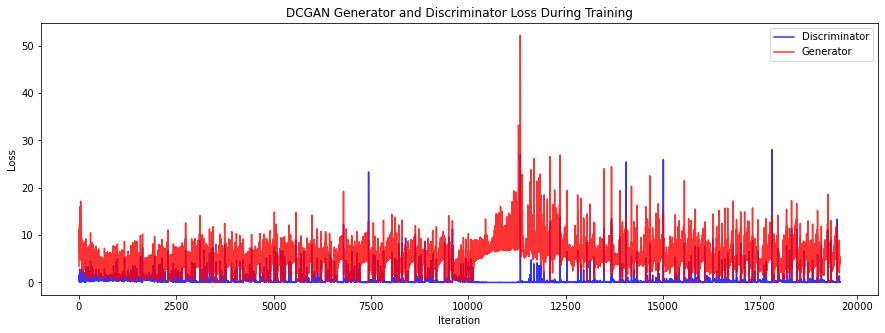

In [13]:
# plotting losses
plt.figure(figsize=(15, 5))
plt.title("DCGAN Generator and Discriminator Loss During Training")
plt.plot(d_losses, label='Discriminator', alpha=0.8, color='blue')
plt.plot(g_losses, label='Generator', alpha=0.8, color='red')
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [9]:
# initialization
generator = Generator(noise_dim).to(device)
discriminator = Discriminator().to(device)

# load the saved models
generator.load_state_dict(torch.load('generator_state_dict.pth'))
discriminator.load_state_dict(torch.load('discriminator_state_dict.pth'))

# set to eval, to avoid any issues
generator.eval()
discriminator.eval()

# creating a random noise amount for testing
test_size = 25
test_noise = torch.randn(test_size, noise_dim, 1, 1, device=device)

# generate images
with torch.no_grad():
    generated_images = generator(test_noise)

#save the images
save_image(generated_images, "test_generated_images.png", nrow=5, normalize=True)

In [10]:
with torch.no_grad():
    real_pred = discriminator(real_images)
    fake_pred = discriminator(fake_images)
    
    real_correct = (real_pred > 0.5).float()
    fake_correct = (fake_pred < 0.5).float()
    
    real_accuracy = real_correct.mean().item()
    fake_accuracy = fake_correct.mean().item()
    total_accuracy = (real_accuracy + fake_accuracy) / 2
    
    print(f"Discriminator accuracy on real images: {real_accuracy:.4f}, fake images: {fake_accuracy:.4f}, total: {total_accuracy:.4f}")

Discriminator accuracy on real images: 0.4000, fake images: 1.0000, total: 0.7000


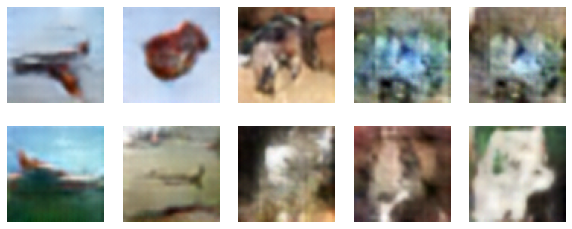

In [12]:
#generating 10 images for the final report
def generate_images(generator, noise_dim, num_images=10):
    
    generator.eval()
    noise = torch.randn(num_images, noise_dim, 1, 1, device='cuda')
    
    # generate images from the noise
    with torch.no_grad():
        generated_images = generator(noise)
        
    generated_images = generated_images.cpu().detach()
    return generated_images

#saving the images to a nice single png
def show_generated_images(generated_images, num_images=10):
    fig, axes = plt.subplots(2, 5, figsize=(10, 4))
    for ax, img in zip(axes.flatten(), generated_images):
        ax.axis('off')
        img = torchvision.utils.make_grid(img, normalize=True)
        ax.imshow(img.permute(1, 2, 0))
    plt.savefig('DCGAN_photos.png')
    plt.show()

#generate images and show them
generated_images = generate_images(generator, noise_dim=100, num_images=10)
show_generated_images(generated_images)